# Overview
This notebook contains my work for exploring the dyno run data.

## Notes
For future analysis having a wide variety of 'objects' and modifications with a continuous target:
1. If possible, decrease variety of 'objects' for feature engineering and statistical purposes
2. If not possible to decrease variety, group instead on similar value for continuous target
    * Choose the peak in normal distribution; if not normally distributed, choose the highest point in the distribution
3. Create features based on the decreased-variety data
4. Make determinations in new features for all observations
5. Categorize 'objects' into cluster features using keywords
    * EX: A Nissan GT-R often has more than 500 horsepower, make a feature called over_500 which encodes Nissan GT-R as True


# Objectives
From a practical perspective, this project should do two things:
1. Determine which factors increase max horsepower for any given car
2. Predict expected horsepower accurately given some information about the car

Exploration is done for step 1, we will lay out the plan below.

## 1. Determine which factors increase horsepower the most
To determine which parts packages and setups increase horsepower overall, we need to do the following things:
1. Limit cars to one overall make and model with same horsepower number
2. Create new version of car_info df for single make+model+horsepower combination
3. Get the stock performance of the single combination
4. Create features for parts, fuel, and more based on 'specs' values
    * Simplify dyno run data to max horsepower, max torque, and max boost
    * Append run's max horsepower, torque, and boost to car_info dataframe
    * Append stock max horsepower, torque, and boost to car_info dataframe
5. Use correlation heatmap to visually identify drivers

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import wrangle
import explore

In [2]:
info, runs = wrangle.prep_explore_MVP()
info.shape, runs.shape

((2217, 10), (918491, 5))

In [3]:
# check for most numerous make+model
info.car_model.value_counts().head(25)

2005 Impreza WRX STI    129
2011 Impreza WRX STI    115
2006 Impreza WRX STI    107
2008 Impreza WRX STI     98
2002 Impreza WRX         83
2004 Impreza WRX         76
2009 GT-R                76
2004 Impreza WRX STI     75
2008 EVO X GSR           75
2007 Impreza WRX STI     74
2005 Impreza WRX         61
2009 Impreza WRX         58
2011 Impreza WRX         58
2006 Impreza WRX         55
2010 Impreza WRX STI     50
2010 Impreza WRX         43
2010 EVO X GSR           40
2012 GT-R                29
2012 Impreza WRX STI     29
2010 GT-R                29
2013 Impreza WRX STI     28
2003 Impreza WRX         28
2011 EVO X GSR           28
2013 Impreza WRX         27
2013 EVO X GSR           26
Name: car_model, dtype: int64

Based on these numbers, we're going with the **WRX STI** as our single make+model, which has 300 - 305 horsepower stock. We will stick with **305 BHP** as our baseline.

In [4]:
# new dataframe for the WRX STI
sti_info = info[info.car_model.str.contains('STI')]
sti_info

,run,name,specs,car_make,car_model,has_keyword,stock_hp,psi,octane,tuned_cpu
3263,4208,Ahmed Belazi,"COBB Tuning Accessport, COBB Tuning Turboback,...",Subaru,2011 Impreza WRX STI,False,305,15,92,True
3271,4261,Sean Kim,"COBB Tuning Accessport, Perrin Turbobck, Coswo...",Subaru,2011 Impreza WRX STI,False,305,19.5,92,True
3237,3827,Matt Songer,"COBB Tuning AccessPORT, Invidia Catted Downpip...",Subaru,2011 Impreza WRX STI,False,305,18,92,True
3541,2703,COBB Tuning,MAF - Sport,Subaru,2011 Impreza WRX STI Hatch,False,305,NaN,NaN,False
4010,4940,Ho Joon Lee,"COBB Tuning Accessport, Nameless TBE, Tial 38m...",Subaru,2013 Impreza WRX STI,False,305,15,92,True
...,...,...,...,...,...,...,...,...,...,...
3161,2762,Jon Luchsinger,"COBB Tuning AccessPORT, COBB Tuning Intake, Pe...",Subaru,2011 Impreza WRX STI,False,305,16,92,True
1561,3711,Brandon Brown,20psi 93 Octane,Subaru,2005 Impreza WRX STI,False,300,NaN,93,False
3253,3981,Bryan Nichols,"COBB Tuning AccessPORT, Invidia Catless Downpi...",Subaru,2011 Impreza WRX STI,False,305,16,92,True
3184,3020,Santos Contreras,Stage 2 93 20psi Sport,Subaru,2011 Impreza WRX STI,False,305,20,93,True


In [5]:
# limit dyno_runs to the WRX STI runs as well
sti_runs = runs[runs.run.isin(sti_info.run)]
sti_runs.head(3)

,run,rpm,hp,torque,boost
17628,61,2040.0,56.0,146.0,3.6
17629,61,2050.0,56.0,146.0,3.7
17630,61,2060.0,57.0,147.0,3.8


# MVP Exploration
Let's gather the max horsepower stats of each run and append the results to our car info dataframe.

In [6]:
# gather max horsepower of each STI run
max_hp_groupby = pd.DataFrame(sti_runs.groupby('run').hp.max())

In [7]:
# append max horsepower to the car info dataframe
df = pd.merge(left=sti_info, right=max_hp_groupby, left_on='run', right_on='run')

In [8]:
# shorten the dataframe to our MVP features
df = df[['hp','psi','octane']].dropna().astype('float')

In [9]:
# fix a few values
df['psi'] = df.psi / np.where(df.psi > 100, 10, 1)

Now let's look at some basic visualizations.

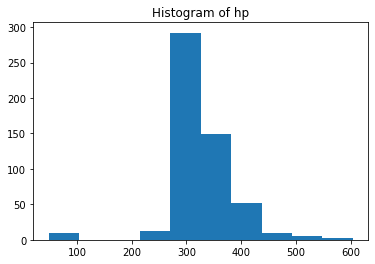

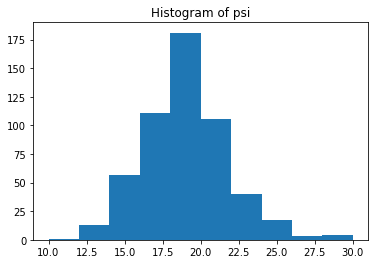

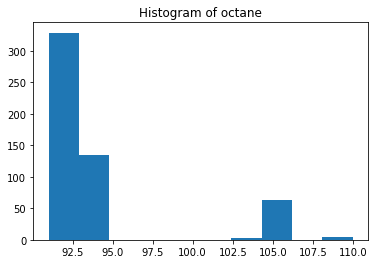

In [10]:
for col in df.columns:
    plt.hist(df[col])
    plt.title('Histogram of ' + col)
    plt.show()

<AxesSubplot:>

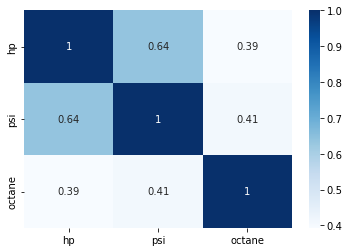

In [11]:
# check correlation heatmap
sns.heatmap(df.corr(), cmap='Blues', annot=True)

## Does Boost PSI Correlate with Horsepower?
- $H_0$: Boost PSI does not correlate with horsepower.
- $H_a$: Boost PSI correlates with horsepower.
- Confidence Interval: 95%

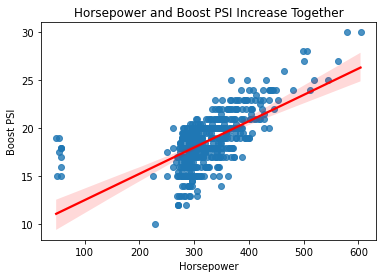

Boost PSI increases as horsepower increases, with 95% confidence.
Slope: 0.02737455972138925
p-value: 1.4188068603670875e-61


In [12]:
# check correlation of horsepower and boost PSI
sns.regplot(df.hp, df.psi, line_kws={'color':'red'})
plt.title('Horsepower and Boost PSI Increase Together')
plt.xlabel('Horsepower')
plt.ylabel('Boost PSI')
plt.show()

slope, _, _, p, _ = stats.linregress(df.hp, df.psi)
if slope > 0 and p < .05:
    print('Boost PSI increases as horsepower increases, with 95% confidence.')
elif slope < 0 and p < .05:
    print('As boost PSI decreases, horsepower increases, with 95% confidence.')
else:
    print('Test does not pass 95% confidence interval. Boost PSI and horsepower are not correlated.')
    
print('Slope:', slope)
print('p-value:', p)

## Does Fuel Octane Correlate with Horsepower?
- $H_0$: Fuel octane does not correlate with horsepower.
- $H_a$: Fuel octane correlates with horsepower.
- Confidence Interval: 95%

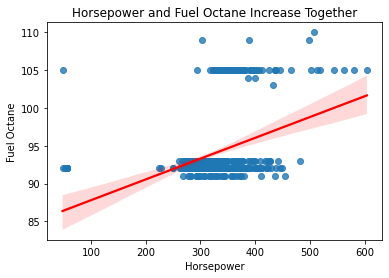

Fuel octane increases as horsepower increases, with 95% confidence.
Slope: 0.027471500274934668
p-value: 3.774176902578124e-21


In [13]:
# check correlation of horsepower and fuel octane
sns.regplot(df.hp, df.octane, line_kws={'color':'red'})
plt.title('Horsepower and Fuel Octane Increase Together')
plt.xlabel('Horsepower')
plt.ylabel('Fuel Octane')
plt.show()

slope, _, _, p, _ = stats.linregress(df.hp, df.octane)

if slope > 0 and p < .05:
    print('Fuel octane increases as horsepower increases, with 95% confidence.')
elif slope < 0 and p < .05:
    print('As fuel octane decreases, horsepower increases, with 95% confidence.')
else:
    print('Test does not pass 95% confidence interval. Fuel octane and horsepower are not correlated.')

print('Slope:', slope)
print('p-value:', p)

## MVP Exploration Takeaways
Using only Subaru WRX STI models (consistent stock horsepower of 305), our exploration shows:
1. Boost PSI positively correlates with horsepower
2. Fuel octane positively correlates with horsepower

These two features will be used in our Minimum-Viable Product (MVP) for modeling.

# Post-MVP Exploration

In [14]:
info, runs = wrangle.prep_explore()

In [15]:
info.head(3)

,run,name,specs,car_make,car_model,stock_hp,psi,octane,tuned_cpu,hp
3263,4208,Ahmed Belazi,"COBB Tuning Accessport, COBB Tuning Turboback,...",Subaru,2011 Impreza WRX STI,305,15.0,92,True,296.0
3271,4261,Sean Kim,"COBB Tuning Accessport, Perrin Turbobck, Coswo...",Subaru,2011 Impreza WRX STI,305,19.5,92,True,317.0
3719,4645,Conrad N,"AMS DP, CNT CBE w/ Cat, K&N Intake, AMS FMIC, ...",Mitsubishi,2011 EVO X GSR,291,25.0,92,False,350.0


We will only use WRX STI again to test the tuned_cpu feature. Our new stock_hp feature was created specifically for modeling, so we won't focus on it for exploration.

In [16]:
# new dataframe for the WRX STI
sti_info = info[info.car_model.str.contains('STI')]
sti_info.head(3)

,run,name,specs,car_make,car_model,stock_hp,psi,octane,tuned_cpu,hp
3263,4208,Ahmed Belazi,"COBB Tuning Accessport, COBB Tuning Turboback,...",Subaru,2011 Impreza WRX STI,305,15.0,92,True,296.0
3271,4261,Sean Kim,"COBB Tuning Accessport, Perrin Turbobck, Coswo...",Subaru,2011 Impreza WRX STI,305,19.5,92,True,317.0
3237,3827,Matt Songer,"COBB Tuning AccessPORT, Invidia Catted Downpip...",Subaru,2011 Impreza WRX STI,305,18.0,92,True,277.0


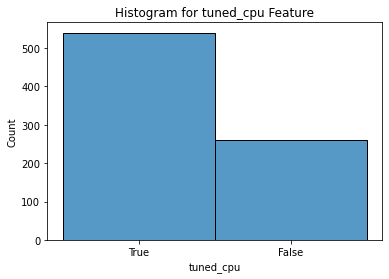

In [17]:
# histogram of tuned_cpu
sns.histplot(sti_info['tuned_cpu'].astype('str'))
plt.title('Histogram for tuned_cpu Feature')
plt.show()

## Do Cars with Tuned CPUs Have Higher Horsepower?
- $H_0$: Cars with tuned CPUs do not have higher horsepower.
- $H_a$: Cars with tuned CPUs have higher horsepower..
- Confidence Interval: 95%

In [18]:
# conduct t-test
t, p = stats.mannwhitneyu(sti_info[sti_info.tuned_cpu].hp,
                          sti_info[~sti_info.tuned_cpu].hp,
                          alternative='greater')

if t > 0 and p < .05:
    print('Cars with tuned CPUs have higher horsepower, with 95% confidence.')
else:
    print('Results do not breach 95% confidence interval, cars with tuned CPUs do not have higher horsepower.')

Results do not breach 95% confidence interval, cars with tuned CPUs do not have higher horsepower.


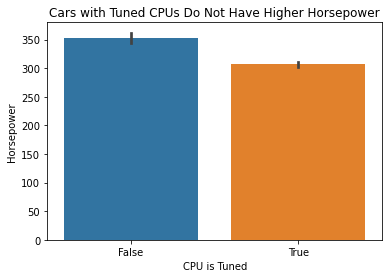

In [19]:
# plot bar chart
sns.barplot(data=sti_info, x='tuned_cpu', y='hp')
plt.title('Cars with Tuned CPUs Do Not Have Higher Horsepower')
plt.xlabel('CPU is Tuned')
plt.ylabel('Horsepower')
plt.show()

## Post-MVP Exploration Takeaways
Our test showed that our feature indicates the opposite of what we expected. The results aren't definitive of CPU-tuning worsening performance, but the results do mean that we should not use this as a feature.